# Travelling Salesman Problem (TSP) via Fast Simulated Annealing (FSA)

## Quick refresher

* $T_0 \in \mathbb{R}$ initial temperature
* $ n_0 \in \mathbb{N} $ and $ \alpha \in \mathbb{R} $  - cooling strategy parameters
* $k$-th step:
  * Evaluate current temperature:
    * $ T = \frac{T_0}{1+(k/n_0)^\alpha} $ for $ \alpha > 0 $,
    * $ T = T_0 \cdot \exp(-(k/n_0)^{-\alpha}) $ otherwise.
  * **Mutate** the solution ``x`` -> ``y``
  * $s = \frac{f_x-f_y}{T}$
  * replace ``x`` if $u < 1/2 + \arctan(s)/\pi$ where $u$ is random (uniform) number
  
Cauchy **mutation operator**:

* mutation perimeter (width) controlled by parameter $r \in \mathbb{R}$
* $ \boldsymbol{\mathsf{x}}_\mathrm{new} = \boldsymbol{\mathsf{x}} + r \cdot \tan{\left(\pi \left(\boldsymbol{\mathsf{r}} - \dfrac{1}{2}\right)\right)} $ where $\boldsymbol{\mathsf{r}}$ is random uniform vector


In [1]:
# Import path to source directory (bit of a hack in Jupyter)
import sys
import os
pwd = %pwd
sys.path.append(os.path.join(pwd, '../src'))

# Ensure modules are reloaded on any change (very useful when developing code on the fly)
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')

In [2]:
# Import extrenal librarires
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Import our code
from heur import ShootAndGo, FastSimulatedAnnealing
from objfun import TSPGrid

## Initialize ``TSPGrid(3, 3)``

In [3]:
# initialization
tsp = TSPGrid(3, 3)

## Referential performance: Random Shooting ($\mathrm{SG}_{0}$) and Steepest Descent ($\mathrm{SG}_{\infty}$)

In [5]:
NUM_RUNS = 1000
maxeval = 1000

In [6]:
def experiment_sg(of, maxeval, num_runs, hmax):
    results = []
    for i in tqdm_notebook(range(num_runs), 'Testing hmax={}'.format(hmax)):
        result = ShootAndGo(of, maxeval=maxeval, hmax=hmax).search() # dict with results of one run
        result['run'] = i
        result['heur'] = 'SG_{}'.format(hmax) # name of the heuristic
        result['hmax'] = hmax
        results.append(result)
    
    return pd.DataFrame(results, columns=['heur', 'run', 'hmax', 'best_x', 'best_y', 'neval'])

In [7]:
table_ref = pd.DataFrame()

for hmax in [0, np.inf]:
    res = experiment_sg(of=tsp, maxeval=maxeval, num_runs=NUM_RUNS, hmax=hmax)
    table_ref = pd.concat([table_ref, res], axis=0)

In [8]:
table_ref.head()

,heur,run,hmax,best_x,best_y,neval
0,SG_0,0,0.0,"[5, 5, 5, 4, 1, 0, 1, 0]",10.000000,inf
1,SG_0,1,0.0,"[2, 4, 3, 4, 3, 2, 1, 0]",10.650282,inf
2,SG_0,2,0.0,"[0, 0, 2, 4, 3, 2, 0, 0]",9.414214,435.000000
3,SG_0,3,0.0,"[2, 0, 1, 0, 0, 2, 1, 0]",10.828427,inf
4,SG_0,4,0.0,"[0, 0, 2, 4, 2, 2, 1, 0]",10.000000,inf


In [9]:
# from: 20170306_Steepest_descent_vs_Random_descent.ipynb#Overall-statistics

def rel(x):
    return len([n for n in x if n < np.inf])/len(x)

def mne(x):
    return np.mean([n for n in x if n < np.inf])

def feo(x):
    return mne(x)/rel(x)

In [10]:
stats_ref = table_ref.pivot_table(
    index=['heur'],
    values=['neval'],
    aggfunc=(rel, mne, feo)
)['neval']
stats_ref = stats_ref.reset_index()

In [11]:
stats_ref

,heur,rel,mne,feo
0,SG_0,0.339,475.348083,1402.206733
1,SG_inf,0.897,340.853958,379.993264


## TSP optimization using TSP

Let's evaluate performance of different temperatures, first.

In [12]:
def experiment_fsa(of, maxeval, num_runs, T0, n0, alpha, r):
    results = []
    for i in tqdm_notebook(range(num_runs), 'Testing T0={}, n0={}, alpha={}, r={}'.format(T0, n0, alpha, r)):
        result = FastSimulatedAnnealing(of, maxeval=maxeval, T0=T0, n0=n0, alpha=alpha, r=0.5).search()
        result['run'] = i
        result['heur'] = 'FSA_{}_{}_{}_{}'.format(T0, n0, alpha, r) # name of the heuristic
        result['T0'] = T0
        result['n0'] = n0
        result['alpha'] = alpha
        result['r'] = r
        results.append(result)
    
    return pd.DataFrame(results, columns=['heur', 'run', 'T0', 'n0', 'alpha', 'r', 'best_x', 'best_y', 'neval'])

In [16]:
table_fsa = pd.DataFrame()

for T0 in [1e-10, 1e-2, 1, np.inf]:
    res = experiment_fsa(of=tsp, maxeval=maxeval, num_runs=NUM_RUNS, T0=T0, n0=1, alpha=2, r=0.5)
    table_fsa = pd.concat([table_fsa, res], axis=0)

In [18]:
stats_fsa = table_fsa.pivot_table(
    index=['heur', 'T0'],
    values=['neval'],
    aggfunc=(rel, mne, feo)
)['neval']
stats_fsa = stats_fsa.reset_index()
stats_fsa.sort_values(by=['T0'])

,heur,T0,rel,mne,feo
2,FSA_1e-10_1_2_0.5,1.000000e-10,0.748,258.493316,345.579299
0,FSA_0.01_1_2_0.5,1.000000e-02,0.732,234.562842,320.441040
1,FSA_1_1_2_0.5,1.000000e+00,0.758,239.361478,315.780313
3,FSA_inf_1_2_0.5,inf,0.432,448.983796,1039.314343


# Analysis

**Can we improve the best configuration ($T_0=1$)?**

Let's carefully analyze the data...

In [42]:
heur = FastSimulatedAnnealing(tsp, maxeval=1000, T0=1, n0=1, alpha=2, r=0.5)
result = heur.search()

In [43]:
print('neval = {}'.format(result['neval']))
print('best_x = {}'.format(result['best_x']))
print('best_y = {}'.format(result['best_y']))

neval = 640
best_x = [0 0 2 4 3 2 0 0]
best_y = 9.414213562373096


In [44]:
log_data = result['log_data'].copy()
log_data = log_data[['step', 'x', 'f_x', 'y', 'f_y', 'T', 'swap']]  # column re-ordering, for better readability
log_data.head(15)

,step,x,f_x,y,f_y,T,swap
0,1,"[3, 1, 3, 3, 3, 0, 0, 0]",15.543204,"[5, 2, 2, 3, 3, 0, 0, 0]",12.472136,0.500000,True
1,2,"[5, 2, 2, 3, 3, 0, 0, 0]",12.472136,"[5, 2, 2, 0, 3, 2, 1, 0]",12.650282,0.200000,False
2,3,"[5, 2, 2, 3, 3, 0, 0, 0]",12.472136,"[6, 2, 2, 3, 3, 0, 1, 0]",14.714777,0.100000,True
3,4,"[6, 2, 2, 3, 3, 0, 1, 0]",14.714777,"[7, 2, 1, 3, 2, 2, 1, 0]",16.779272,0.058824,False
4,5,"[6, 2, 2, 3, 3, 0, 1, 0]",14.714777,"[6, 4, 1, 4, 3, 0, 0, 0]",14.714777,0.038462,False
5,6,"[6, 2, 2, 3, 3, 0, 1, 0]",14.714777,"[6, 2, 3, 2, 3, 0, 1, 0]",17.365058,0.027027,False
6,7,"[6, 2, 2, 3, 3, 0, 1, 0]",14.714777,"[7, 2, 2, 4, 3, 0, 1, 0]",14.714777,0.020000,True
7,8,"[7, 2, 2, 4, 3, 0, 1, 0]",14.714777,"[7, 2, 3, 4, 3, 1, 1, 0]",15.721349,0.015385,False
8,9,"[7, 2, 2, 4, 3, 0, 1, 0]",14.714777,"[7, 2, 1, 3, 3, 0, 1, 0]",16.957417,0.012195,False
9,10,"[7, 2, 2, 4, 3, 0, 1, 0]",14.714777,"[7, 2, 3, 4, 3, 2, 1, 0]",14.307136,0.009901,True


In [45]:
def plot_compare(step_data, ax1_col, ax1_label, ax2_col, ax2_label):
    fig, ax1 = plt.subplots()

    k = step_data.index.values
    T = step_data[ax1_col]
    ax1.plot(k, T, 'b-')
    ax1.set_xlabel('Step')
    ax1.set_ylabel(ax1_label, color='b')
    for tl in ax1.get_yticklabels():
        tl.set_color('b')

    ax2 = ax1.twinx()
    s2 = step_data[ax2_col]
    ax2.plot(k, s2, 'r.')
    ax2.set_ylabel(ax2_label, color='r')
    for tl in ax2.get_yticklabels():
        tl.set_color('r')

    plt.show()

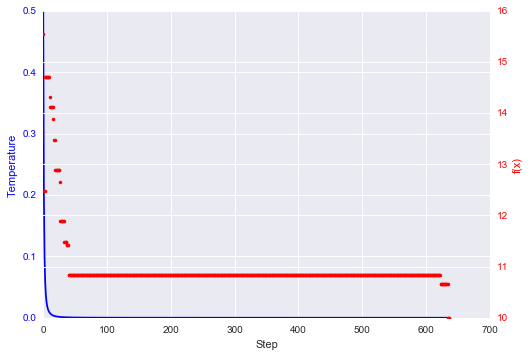

In [46]:
plot_compare(log_data, 'T', 'Temperature', 'f_x', 'f(x)')

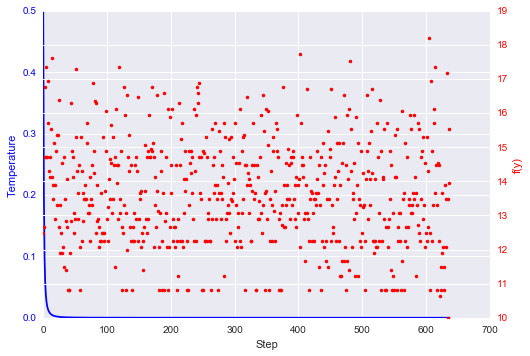

In [47]:
plot_compare(log_data, 'T', 'Temperature', 'f_y', 'f(y)')

### Slower cooling?

Let's double $n_0$:

In [51]:
heur = FastSimulatedAnnealing(tsp, maxeval=1000, T0=1, n0=2, alpha=2, r=0.5)
result = heur.search()
print('neval = {}'.format(result['neval']))
print('best_x = {}'.format(result['best_x']))
print('best_y = {}'.format(result['best_y']))

neval = 150
best_x = [0 2 0 1 3 2 1 0]
best_y = 9.414213562373096


In [52]:
log_data = result['log_data'].copy()
log_data = log_data[['step', 'x', 'f_x', 'y', 'f_y', 'T', 'swap']]  # column re-ordering, for better readability

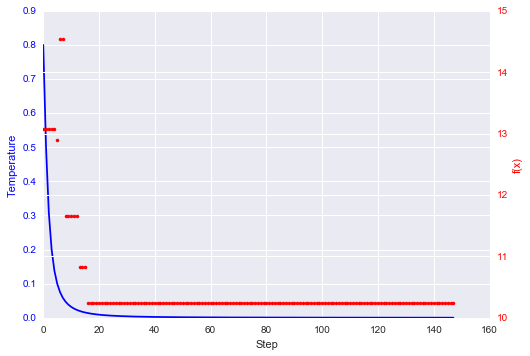

In [53]:
plot_compare(log_data, 'T', 'Temperature', 'f_x', 'f(x)')

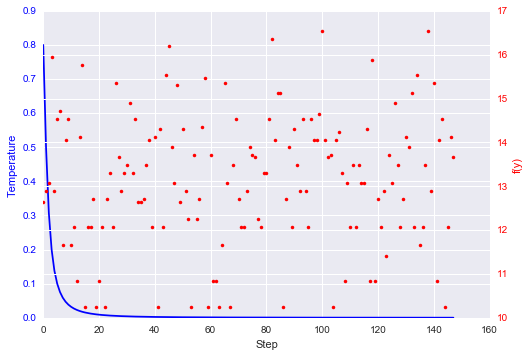

In [54]:
plot_compare(log_data, 'T', 'Temperature', 'f_y', 'f(y)')

**Thorough testing**:

In [59]:
for n0 in [2, 3, 5, 10]:
    res = experiment_fsa(of=tsp, maxeval=maxeval, num_runs=NUM_RUNS, T0=1, n0=n0, alpha=2, r=0.5)
    table_fsa = pd.concat([table_fsa, res], axis=0)

In [60]:
stats_fsa = table_fsa.pivot_table(
    index=['heur', 'T0', 'n0'],
    values=['neval'],
    aggfunc=(rel, mne, feo)
)['neval']
stats_fsa = stats_fsa.reset_index()
stats_fsa.sort_values(by=['T0', 'n0'])

,heur,T0,n0,rel,mne,feo
6,FSA_1e-10_1_2_0.5,1.000000e-10,1,0.748,258.493316,345.579299
0,FSA_0.01_1_2_0.5,1.000000e-02,1,0.732,234.562842,320.441040
2,FSA_1_1_2_0.5,1.000000e+00,1,0.758,239.361478,315.780313
3,FSA_1_2_2_0.5,1.000000e+00,2,0.757,238.587847,315.175491
4,FSA_1_3_2_0.5,1.000000e+00,3,0.737,231.522388,314.141639
5,FSA_1_5_2_0.5,1.000000e+00,5,0.739,226.411367,306.375327
1,FSA_1_10_2_0.5,1.000000e+00,10,0.760,240.114474,315.940097
7,FSA_inf_1_2_0.5,inf,1,0.432,448.983796,1039.314343


### Is the mutation $r$ adequate?

In [61]:
log_data['jump_length'] = log_data.apply(lambda r: np.linalg.norm(r['x'] - r['y']), axis=1)
log_data.head(10)

,step,x,f_x,y,f_y,T,swap,jump_length
0,1,"[0, 3, 0, 2, 3, 1, 1, 0]",13.071068,"[1, 3, 0, 2, 3, 2, 1, 0]",12.650282,0.800000,False,1.414214
1,2,"[0, 3, 0, 2, 3, 1, 1, 0]",13.071068,"[0, 2, 5, 2, 3, 2, 0, 0]",12.892922,0.500000,False,5.291503
2,3,"[0, 3, 0, 2, 3, 1, 1, 0]",13.071068,"[0, 3, 0, 2, 3, 1, 1, 0]",13.071068,0.307692,False,0.000000
3,4,"[0, 3, 0, 2, 3, 1, 1, 0]",13.071068,"[1, 1, 0, 2, 3, 0, 1, 0]",15.950845,0.200000,False,2.449490
4,5,"[0, 3, 0, 2, 3, 1, 1, 0]",13.071068,"[0, 3, 0, 1, 3, 0, 1, 0]",12.892922,0.137931,True,1.414214
5,6,"[0, 3, 0, 1, 3, 0, 1, 0]",12.892922,"[0, 3, 0, 0, 3, 1, 0, 0]",14.536631,0.100000,True,1.732051
6,7,"[0, 3, 0, 0, 3, 1, 0, 0]",14.536631,"[1, 5, 3, 0, 3, 1, 0, 0]",14.714777,0.075472,False,3.741657
7,8,"[0, 3, 0, 0, 3, 1, 0, 0]",14.536631,"[0, 3, 0, 1, 3, 1, 1, 0]",11.656854,0.058824,True,1.414214
8,9,"[0, 3, 0, 1, 3, 1, 1, 0]",11.656854,"[0, 3, 1, 2, 3, 1, 1, 0]",14.064495,0.047059,False,1.414214
9,10,"[0, 3, 0, 1, 3, 1, 1, 0]",11.656854,"[0, 4, 1, 1, 3, 0, 1, 0]",14.536631,0.038462,False,1.732051


In [62]:
log_data['jump_length'].describe()

count    148.000000
mean       2.334011
std        1.540285
min        0.000000
25%        1.414214
50%        1.866025
75%        3.162278
max        7.141428
Name: jump_length, dtype: float64

In [63]:
for r in [.1, .25, .75, 1, 2]:
    res = experiment_fsa(of=tsp, maxeval=maxeval, num_runs=NUM_RUNS, T0=1, n0=5, alpha=2, r=r)
    table_fsa = pd.concat([table_fsa, res], axis=0)

In [66]:
stats_fsa = table_fsa.pivot_table(
    index=['heur', 'T0', 'n0', 'r'],
    values=['neval'],
    aggfunc=(rel, mne, feo)
)['neval']
stats_fsa = stats_fsa.reset_index()
stats_fsa.sort_values(by=['T0', 'n0', 'r'])

,heur,T0,n0,r,rel,mne,feo
11,FSA_1e-10_1_2_0.5,1.000000e-10,1,0.50,0.748,258.493316,345.579299
0,FSA_0.01_1_2_0.5,1.000000e-02,1,0.50,0.732,234.562842,320.441040
2,FSA_1_1_2_0.5,1.000000e+00,1,0.50,0.758,239.361478,315.780313
3,FSA_1_2_2_0.5,1.000000e+00,2,0.50,0.757,238.587847,315.175491
4,FSA_1_3_2_0.5,1.000000e+00,3,0.50,0.737,231.522388,314.141639
5,FSA_1_5_2_0.1,1.000000e+00,5,0.10,0.746,228.781501,306.677616
6,FSA_1_5_2_0.25,1.000000e+00,5,0.25,0.742,249.121294,335.742984
7,FSA_1_5_2_0.5,1.000000e+00,5,0.50,0.739,226.411367,306.375327
8,FSA_1_5_2_0.75,1.000000e+00,5,0.75,0.750,254.409333,339.212444
9,FSA_1_5_2_1,1.000000e+00,5,1.00,0.741,219.843455,296.684824


The best performing instance of FSA, according to $FEO$:

In [69]:
stats_fsa.sort_values(by=['feo']).head(1)

,heur,T0,n0,r,rel,mne,feo
9,FSA_1_5_2_1,1.0,5,1.0,0.741,219.843455,296.684824


## Conclusion

When assessing heuristic performance, always try to combine _prior_ knowledge with _posterior_ data collected during experimental phase. On the other hand, exhaustive grid parameter space search can be useful as well, but you will learn much more using this iterative approach.

## Assignment

1. Could you further improve performance of FSA on this instance of TSP?
2. We have performed analyses of the `log_data` contents on a single run of a heuristic. Try to aggregate and make use o fthese statistics on multiple eperimental runs.
3. When FSA search is successful, the last objective function call is missing in the `log_data` output variable. Could you improve this behaviour?